In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time
import joblib

import category_encoders as ce
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 3

In [4]:
OOF_PATH = Path("../data/oof/lgbm-dart-linear-bce-dsv02")
SUB_PATH = Path("../data/subs/lgbm-dart-linear-bce-dsv02")
ART_PATH = Path("../artifacts/lgbm-dart-linear-bce-dsv02")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
!ls ../data/processed/dsv02

test.parquet  train.parquet


In [6]:
train = pd.read_parquet("../data/processed/dsv02/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [7]:
input_feats = train.columns.tolist()
categ_feats = [
    'B_30_first', 'B_38_first', 'D_114_first', 'D_116_first', 'D_117_first', 
    'D_120_first', 'D_126_first', 'D_63_first', 'D_64_first', 'D_66_first', 'D_68_first',
    'B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 
    'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last',
]
numeric_feats = [col for col in input_feats if col not in categ_feats]

len(input_feats)

1562

In [8]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [9]:
model_params = {
    'boosting':'dart',
    'linear_tree':True,
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.15,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 3000,
    'linear_lambda':10,
    #'path_smooth': 30.4965047619009,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [10]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    scalers = list()
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
        
        scaler = StandardScaler(with_mean=True, with_std=True)
        scaler.fit(train_df[numeric_feats].values)
        train_df[numeric_feats] = scaler.transform(train_df[numeric_feats].values)
        valid_df[numeric_feats] = scaler.transform(valid_df[numeric_feats].values)
        
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=4000,
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        scalers.append(scaler)
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return scalers,models,oof

In [11]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/3 ################################
######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.760519	valid_0's recall_at4: 0.616595	valid_0's norm_gini: 0.904443
[100]	valid_0's amex_metric: 0.767555	valid_0's recall_at4: 0.625936	valid_0's norm_gini: 0.909174
[150]	valid_0's amex_metric: 0.771439	valid_0's recall_at4: 0.631448	valid_0's norm_gini: 0.91143
[200]	valid_0's amex_metric: 0.773986	valid_0's recall_at4: 0.635235	valid_0's norm_gini: 0.912736
[250]	valid_0's amex_metric: 0.776551	valid_0's recall_at4: 0.638643	valid_0's norm_gini: 0.914459
[300]	valid_0's amex_metric: 0.779412	valid_0's recall_at4: 0.642935	valid_0's norm_gini: 0.915889
[350]	valid_0's amex_metric: 0.781703	valid_0's recall_at4: 0.646512	valid_0's norm_gini: 0.916894
[400]	valid_0's amex_metric: 0.782236	valid_0's recall_at4: 0.646933	valid_0's norm_gini: 0.917539
[450]	valid_0's amex_metric: 0.784662	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.918647
[500]	valid_0's amex_metric: 0.78651	valid_0's recall_at4: 0.653286	valid_0's norm_gini: 0.919733
[550]	valid_0

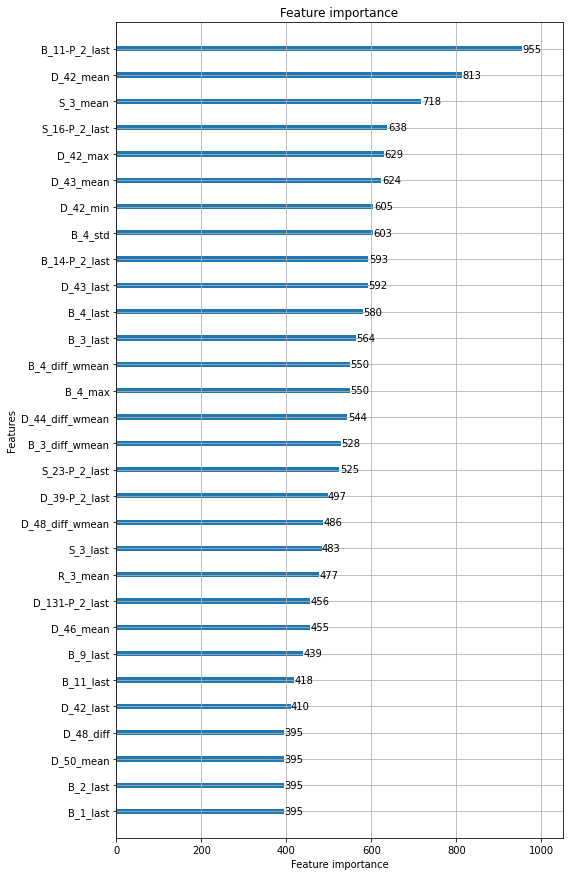

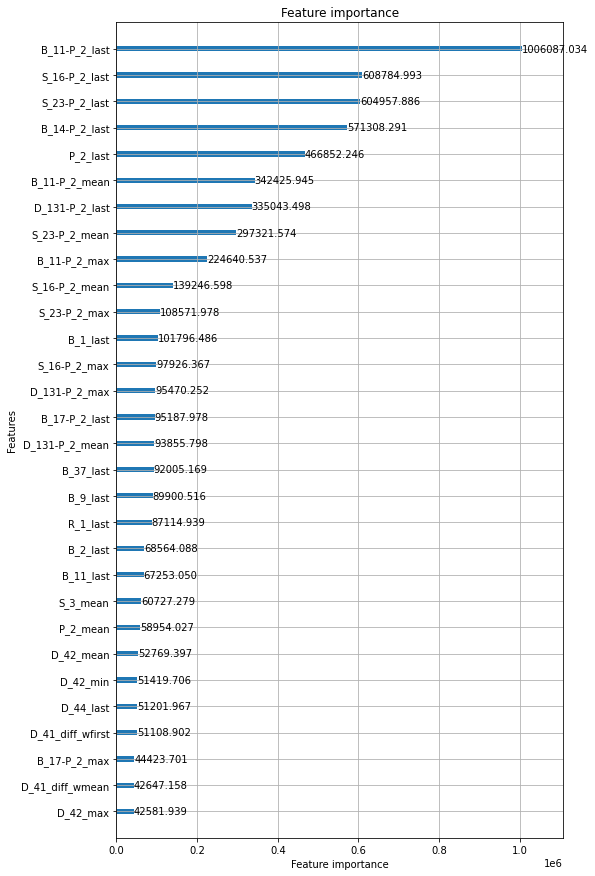

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.757538	valid_0's recall_at4: 0.611462	valid_0's norm_gini: 0.903615
[100]	valid_0's amex_metric: 0.763864	valid_0's recall_at4: 0.619414	valid_0's norm_gini: 0.908313
[150]	valid_0's amex_metric: 0.767851	valid_0's recall_at4: 0.625431	valid_0's norm_gini: 0.910272
[200]	valid_0's amex_metric: 0.770036	valid_0's recall_at4: 0.628377	valid_0's norm_gini: 0.911694
[250]	valid_0's amex_metric: 0.773783	valid_0's recall_at4: 0.63431	valid_0's norm_gini: 0.913256
[300]	valid_0's amex_metric: 0.775006	valid_0's recall_at4: 0.635319	valid_0's norm_gini: 0.914692
[350]	valid_0's amex_metric: 0.777738	valid_0's recall_at4: 0.639948	valid_0's norm_gini: 0.915529
[400]	valid_0's amex_metric: 0.778557	valid_0's recall_at4: 0.640916	valid_0's norm_gini: 0.916199
[450]	valid_0's amex_metric: 0.780964	valid_0's recall_at4: 0.644618	valid_0's norm_gini: 0.91731
[500]	valid_0's amex_metric: 0.783652	valid_0's recall_at4: 0.64891	valid_0's norm_gini: 0.918394
[550]	valid_0'

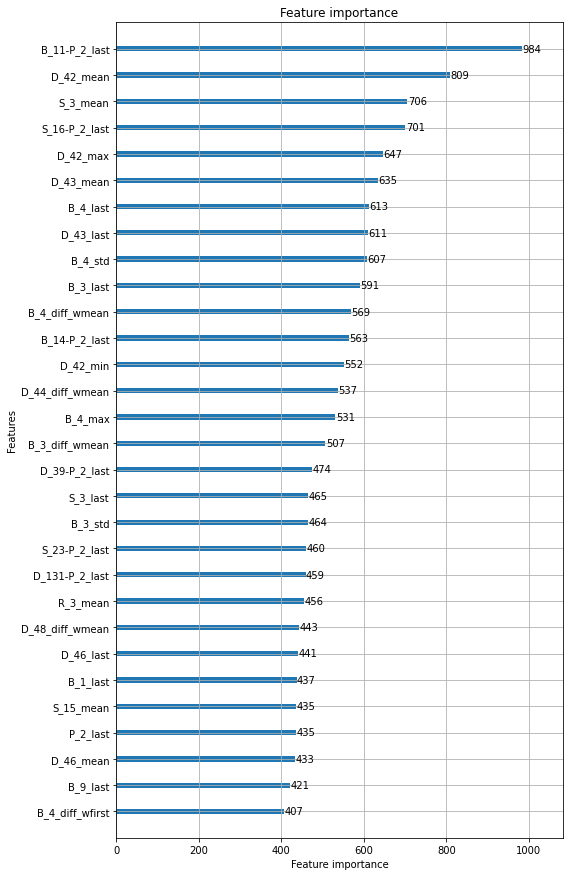

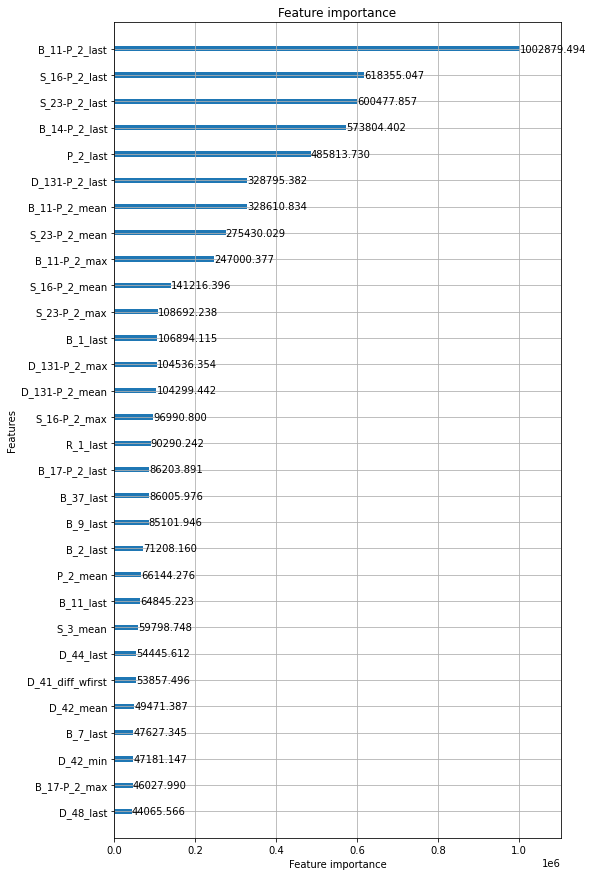

######################################## training model 3/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.753774	valid_0's recall_at4: 0.605192	valid_0's norm_gini: 0.902355
[100]	valid_0's amex_metric: 0.759775	valid_0's recall_at4: 0.612177	valid_0's norm_gini: 0.907373
[150]	valid_0's amex_metric: 0.76307	valid_0's recall_at4: 0.616637	valid_0's norm_gini: 0.909504
[200]	valid_0's amex_metric: 0.766878	valid_0's recall_at4: 0.622949	valid_0's norm_gini: 0.910806
[250]	valid_0's amex_metric: 0.770594	valid_0's recall_at4: 0.628797	valid_0's norm_gini: 0.912391
[300]	valid_0's amex_metric: 0.772936	valid_0's recall_at4: 0.632248	valid_0's norm_gini: 0.913624
[350]	valid_0's amex_metric: 0.774189	valid_0's recall_at4: 0.633889	valid_0's norm_gini: 0.914489
[400]	valid_0's amex_metric: 0.775665	valid_0's recall_at4: 0.636287	valid_0's norm_gini: 0.915043
[450]	valid_0's amex_metric: 0.777805	valid_0's recall_at4: 0.639485	valid_0's norm_gini: 0.916124
[500]	valid_0's amex_metric: 0.780148	valid_0's recall_at4: 0.643104	valid_0's norm_gini: 0.917192
[550]	valid_

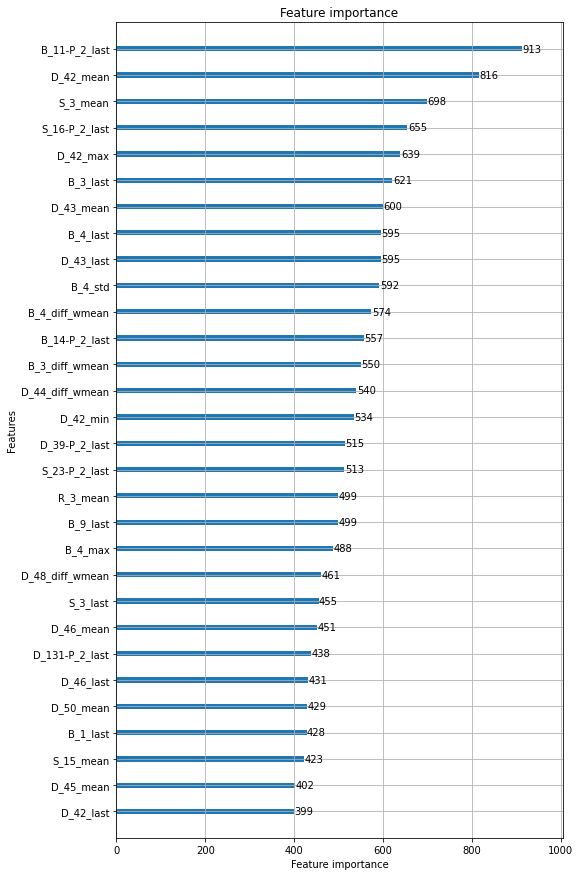

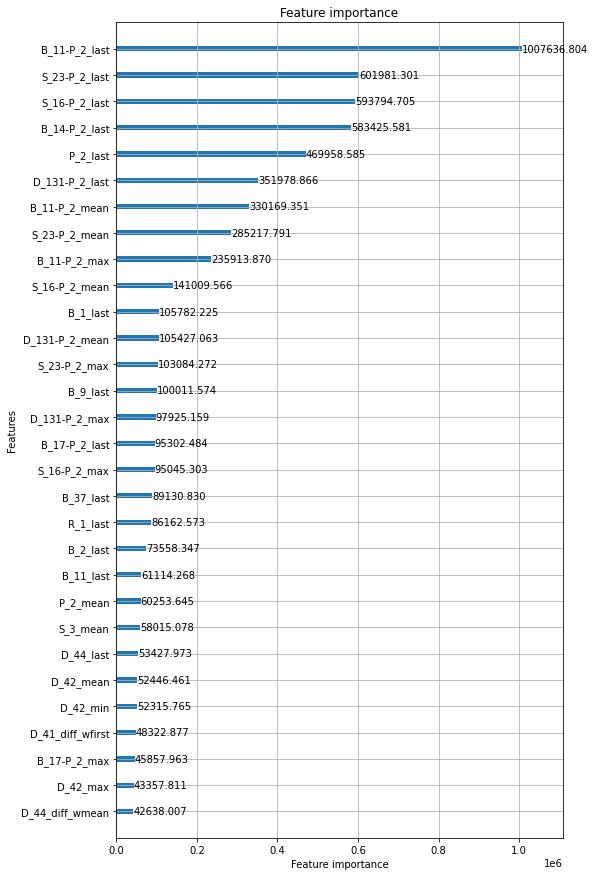

######################################## training model 4/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.75357	valid_0's recall_at4: 0.605302	valid_0's norm_gini: 0.901838
[100]	valid_0's amex_metric: 0.762018	valid_0's recall_at4: 0.617084	valid_0's norm_gini: 0.906953
[150]	valid_0's amex_metric: 0.766213	valid_0's recall_at4: 0.623354	valid_0's norm_gini: 0.909073
[200]	valid_0's amex_metric: 0.768303	valid_0's recall_at4: 0.626131	valid_0's norm_gini: 0.910475
[250]	valid_0's amex_metric: 0.770034	valid_0's recall_at4: 0.628109	valid_0's norm_gini: 0.91196
[300]	valid_0's amex_metric: 0.77273	valid_0's recall_at4: 0.632022	valid_0's norm_gini: 0.913438
[350]	valid_0's amex_metric: 0.774943	valid_0's recall_at4: 0.635472	valid_0's norm_gini: 0.914413
[400]	valid_0's amex_metric: 0.775147	valid_0's recall_at4: 0.635178	valid_0's norm_gini: 0.915115
[450]	valid_0's amex_metric: 0.77664	valid_0's recall_at4: 0.637113	valid_0's norm_gini: 0.916167
[500]	valid_0's amex_metric: 0.778776	valid_0's recall_at4: 0.640269	valid_0's norm_gini: 0.917283
[550]	valid_0's

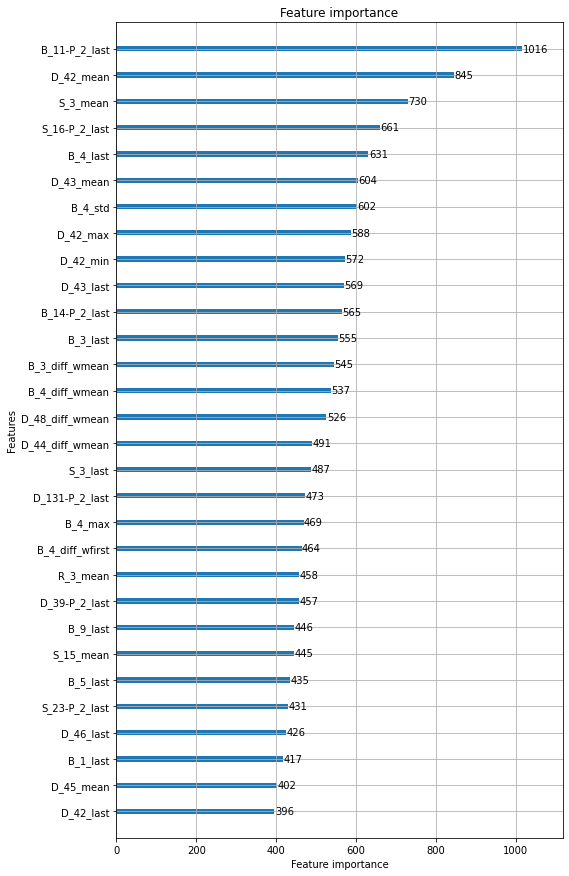

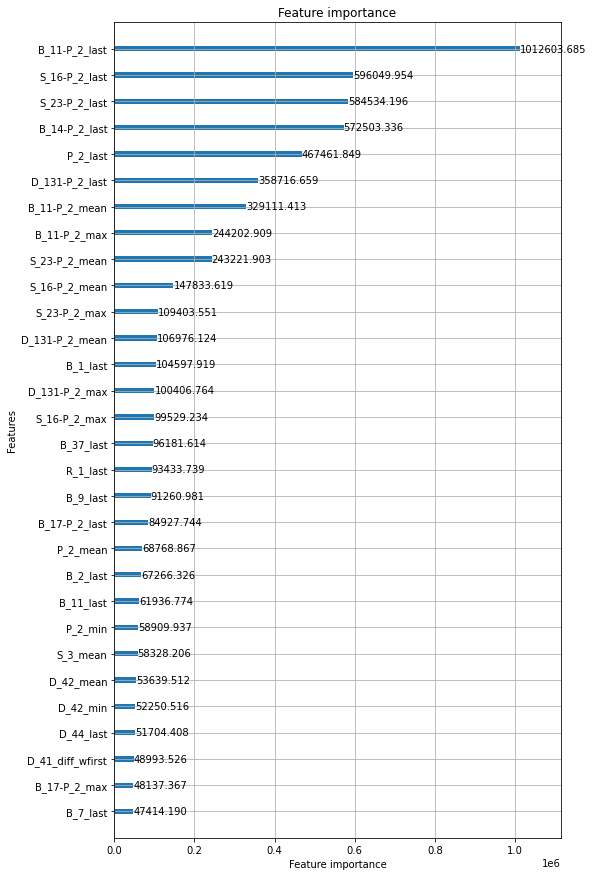

######################################## training model 5/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.761962	valid_0's recall_at4: 0.617883	valid_0's norm_gini: 0.90604
[100]	valid_0's amex_metric: 0.770113	valid_0's recall_at4: 0.629539	valid_0's norm_gini: 0.910687
[150]	valid_0's amex_metric: 0.77325	valid_0's recall_at4: 0.633663	valid_0's norm_gini: 0.912838
[200]	valid_0's amex_metric: 0.775404	valid_0's recall_at4: 0.636693	valid_0's norm_gini: 0.914116
[250]	valid_0's amex_metric: 0.778465	valid_0's recall_at4: 0.641111	valid_0's norm_gini: 0.915819
[300]	valid_0's amex_metric: 0.781421	valid_0's recall_at4: 0.645697	valid_0's norm_gini: 0.917144
[350]	valid_0's amex_metric: 0.783789	valid_0's recall_at4: 0.649442	valid_0's norm_gini: 0.918135
[400]	valid_0's amex_metric: 0.784553	valid_0's recall_at4: 0.650368	valid_0's norm_gini: 0.918739
[450]	valid_0's amex_metric: 0.786645	valid_0's recall_at4: 0.653566	valid_0's norm_gini: 0.919723
[500]	valid_0's amex_metric: 0.78772	valid_0's recall_at4: 0.654534	valid_0's norm_gini: 0.920907
[550]	valid_0'

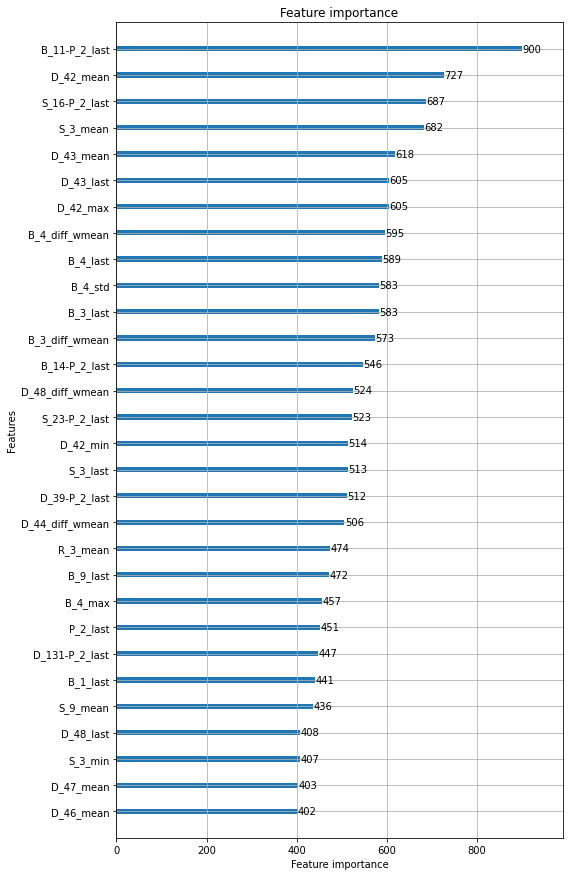

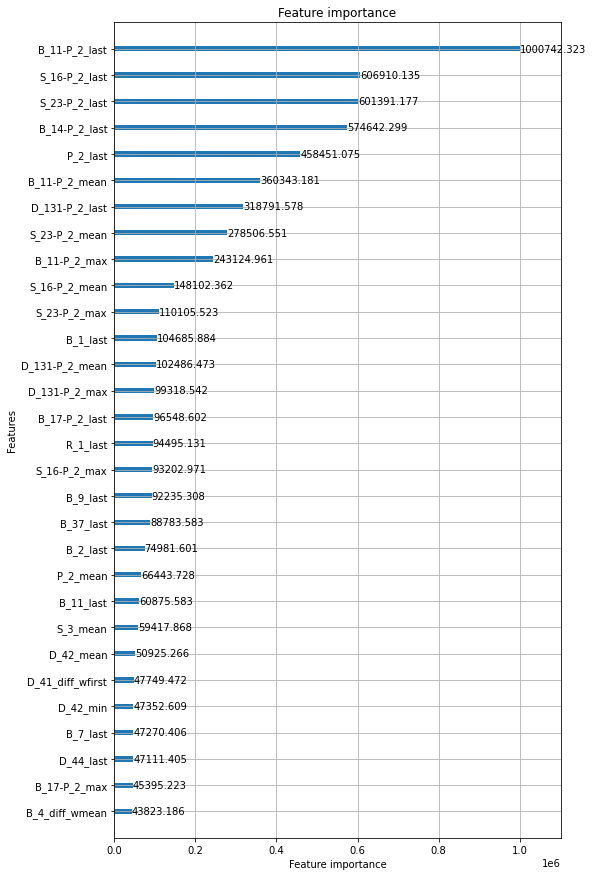

Training time: 118.79400589466096 min.
OOF recall_at4: 0.6681590197596526
OOF normalized_gini: 0.9256117403643249
OOF competition metric: 0.7968853800619888
############################### repeated cross-validation step: 2/3 ################################
######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.758111	valid_0's recall_at4: 0.612135	valid_0's norm_gini: 0.904087
[100]	valid_0's amex_metric: 0.766842	valid_0's recall_at4: 0.624548	valid_0's norm_gini: 0.909136
[150]	valid_0's amex_metric: 0.7702	valid_0's recall_at4: 0.629218	valid_0's norm_gini: 0.911182
[200]	valid_0's amex_metric: 0.772606	valid_0's recall_at4: 0.632626	valid_0's norm_gini: 0.912586
[250]	valid_0's amex_metric: 0.776663	valid_0's recall_at4: 0.639064	valid_0's norm_gini: 0.914261
[300]	valid_0's amex_metric: 0.77848	valid_0's recall_at4: 0.641252	valid_0's norm_gini: 0.915708
[350]	valid_0's amex_metric: 0.780979	valid_0's recall_at4: 0.645334	valid_0's norm_gini: 0.916625
[400]	valid_0's amex_metric: 0.781407	valid_0's recall_at4: 0.645502	valid_0's norm_gini: 0.917311
[450]	valid_0's amex_metric: 0.783228	valid_0's recall_at4: 0.648111	valid_0's norm_gini: 0.918345
[500]	valid_0's amex_metric: 0.785609	valid_0's recall_at4: 0.651771	valid_0's norm_gini: 0.919446
[550]	valid_0'

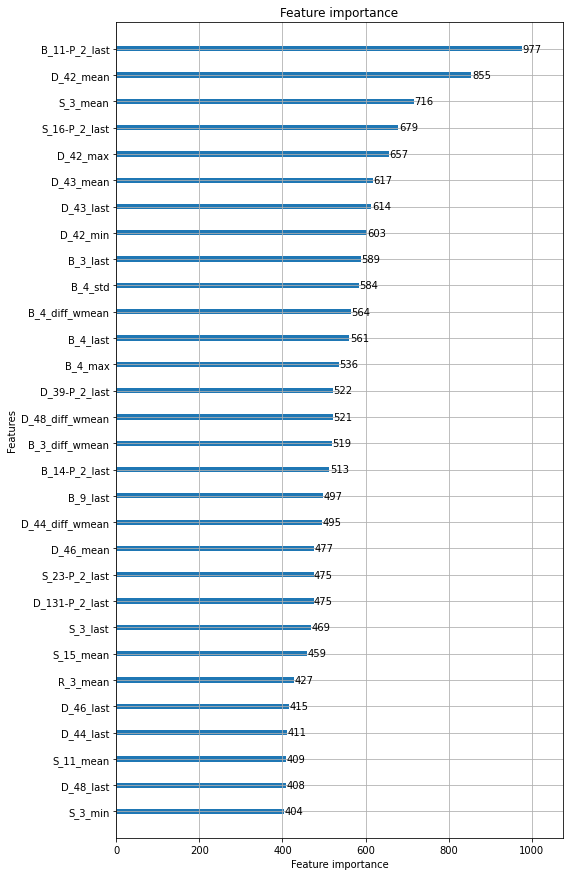

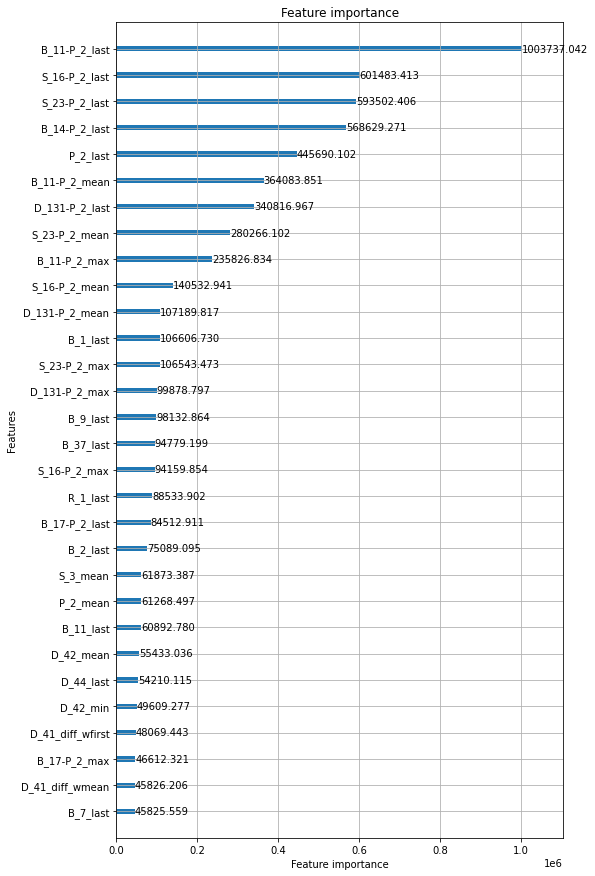

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] [LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.756038	valid_0's recall_at4: 0.608685	valid_0's norm_gini: 0.903392
[100]	valid_0's amex_metric: 0.762788	valid_0's recall_at4: 0.617605	valid_0's norm_gini: 0.907972
[150]	valid_0's amex_metric: 0.765736	valid_0's recall_at4: 0.621266	valid_0's norm_gini: 0.910206
[200]	valid_0's amex_metric: 0.76782	valid_0's recall_at4: 0.624169	valid_0's norm_gini: 0.911472
[250]	valid_0's amex_metric: 0.772658	valid_0's recall_at4: 0.632164	valid_0's norm_gini: 0.913153
[300]	valid_0's amex_metric: 0.775041	valid_0's recall_at4: 0.635656	valid_0's norm_gini: 0.914427
[350]	valid_0's amex_metric: 0.776532	valid_0's recall_at4: 0.63776	valid_0's norm_gini: 0.915305
[400]	valid_0's amex_metric: 0.776641	valid_0's recall_at4: 0.637213	valid_0's norm_gini: 0.916068
[450]	valid_0's amex_metric: 0.77865	valid_0's recall_at4: 0.640326	valid_0's norm_gini: 0.916973
[500]	valid_0's amex_metric: 0.780896	valid_0's recall_at4: 0.643693	valid_0's norm_gini: 0.9181
[550]	valid_0's 

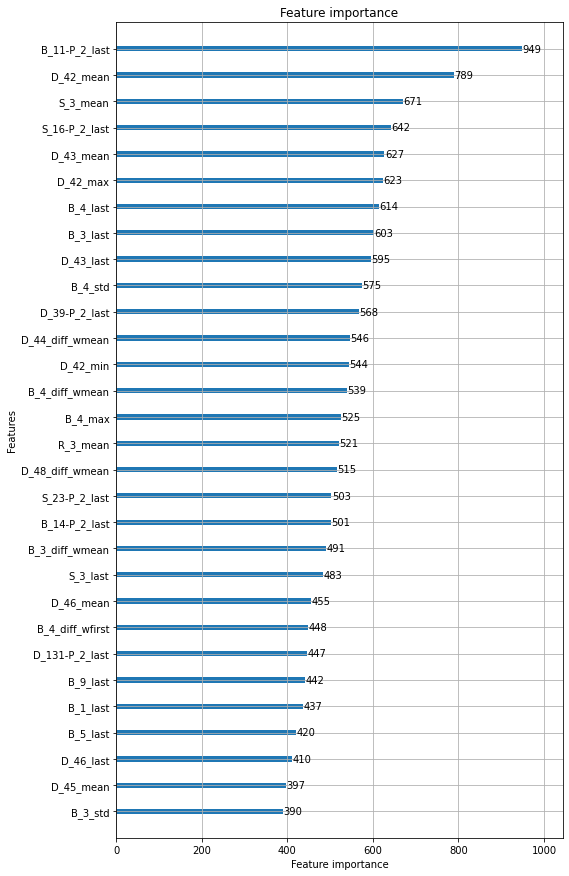

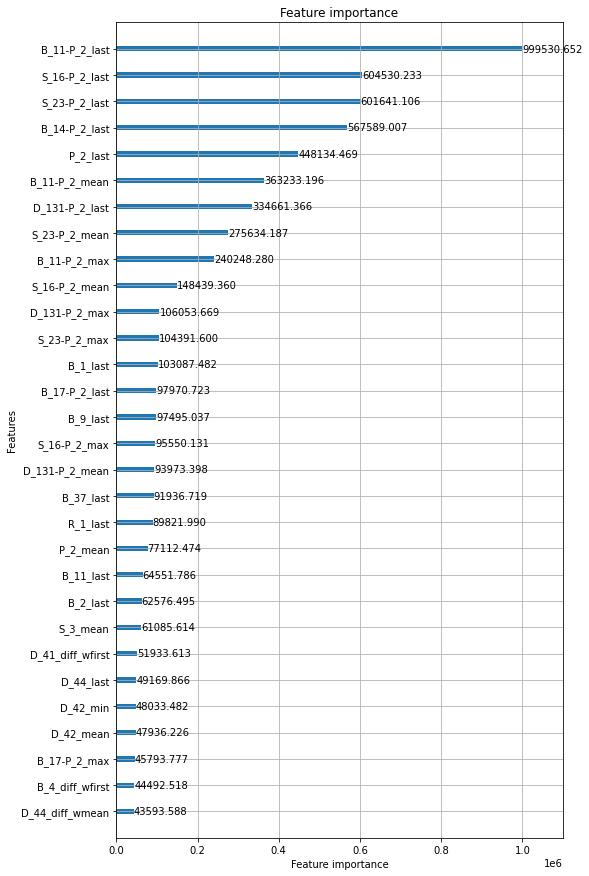

######################################## training model 3/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.753237	valid_0's recall_at4: 0.604393	valid_0's norm_gini: 0.902081
[100]	valid_0's amex_metric: 0.760624	valid_0's recall_at4: 0.614491	valid_0's norm_gini: 0.906758
[150]	valid_0's amex_metric: 0.764021	valid_0's recall_at4: 0.619204	valid_0's norm_gini: 0.908837
[200]	valid_0's amex_metric: 0.766357	valid_0's recall_at4: 0.622444	valid_0's norm_gini: 0.910271
[250]	valid_0's amex_metric: 0.769022	valid_0's recall_at4: 0.626189	valid_0's norm_gini: 0.911856
[300]	valid_0's amex_metric: 0.772347	valid_0's recall_at4: 0.63128	valid_0's norm_gini: 0.913413
[350]	valid_0's amex_metric: 0.774043	valid_0's recall_at4: 0.633636	valid_0's norm_gini: 0.914449
[400]	valid_0's amex_metric: 0.774885	valid_0's recall_at4: 0.634688	valid_0's norm_gini: 0.915081
[450]	valid_0's amex_metric: 0.776746	valid_0's recall_at4: 0.637297	valid_0's norm_gini: 0.916195
[500]	valid_0's amex_metric: 0.779258	valid_0's recall_at4: 0.641084	valid_0's norm_gini: 0.917433
[550]	valid_

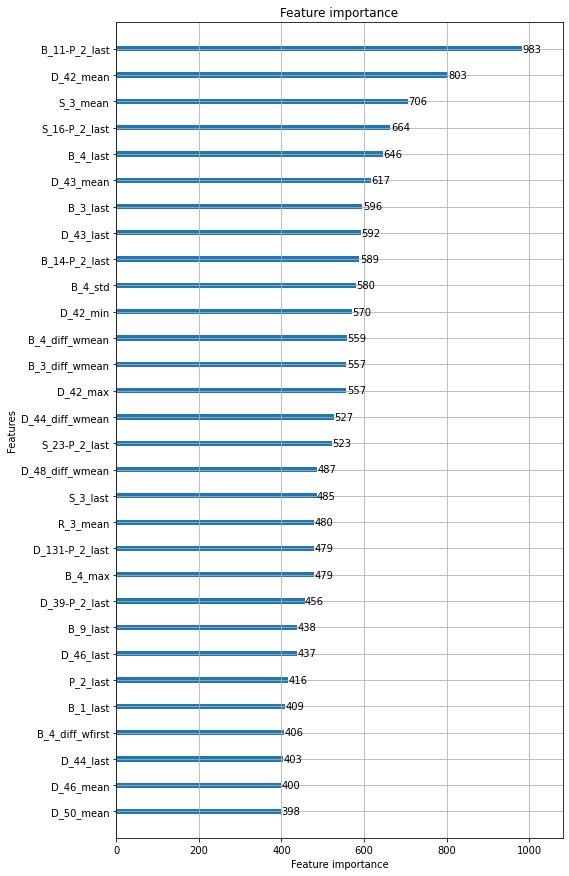

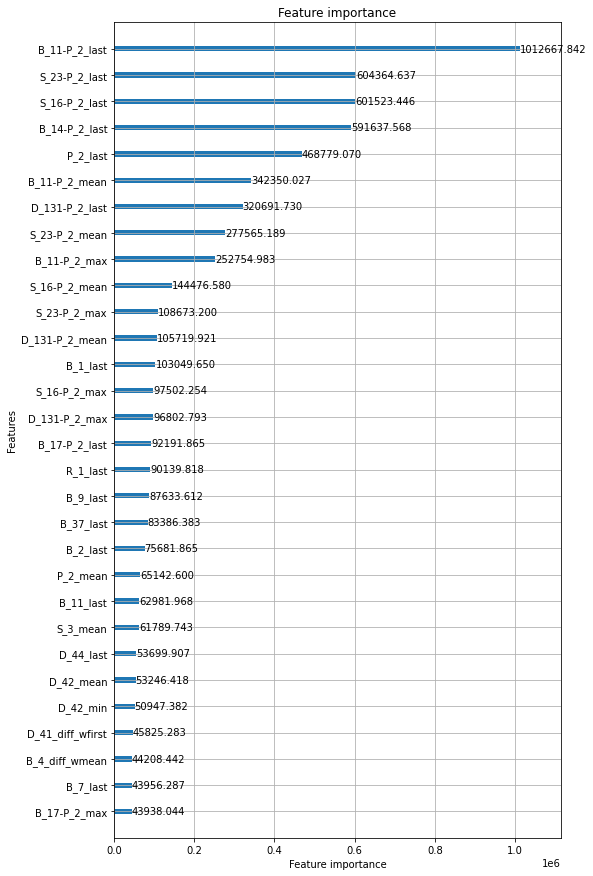

######################################## training model 4/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.758429	valid_0's recall_at4: 0.612708	valid_0's norm_gini: 0.904151
[100]	valid_0's amex_metric: 0.767154	valid_0's recall_at4: 0.625121	valid_0's norm_gini: 0.909188
[150]	valid_0's amex_metric: 0.76973	valid_0's recall_at4: 0.628277	valid_0's norm_gini: 0.911183
[200]	valid_0's amex_metric: 0.771846	valid_0's recall_at4: 0.631222	valid_0's norm_gini: 0.912469
[250]	valid_0's amex_metric: 0.775265	valid_0's recall_at4: 0.636398	valid_0's norm_gini: 0.914132
[300]	valid_0's amex_metric: 0.778136	valid_0's recall_at4: 0.640816	valid_0's norm_gini: 0.915455
[350]	valid_0's amex_metric: 0.780237	valid_0's recall_at4: 0.643972	valid_0's norm_gini: 0.916502
[400]	valid_0's amex_metric: 0.78121	valid_0's recall_at4: 0.645277	valid_0's norm_gini: 0.917143
[450]	valid_0's amex_metric: 0.783174	valid_0's recall_at4: 0.64818	valid_0's norm_gini: 0.918169
[500]	valid_0's amex_metric: 0.785409	valid_0's recall_at4: 0.651588	valid_0's norm_gini: 0.919229
[550]	valid_0'

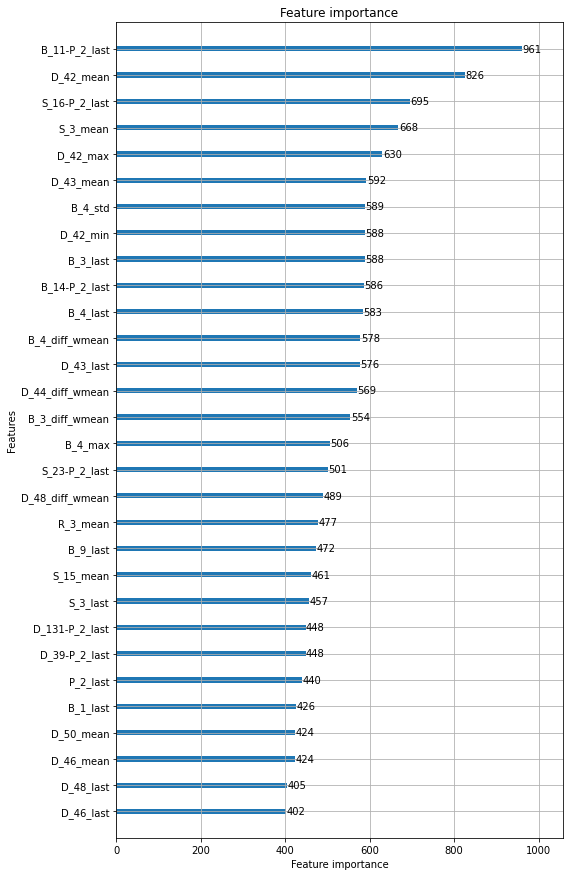

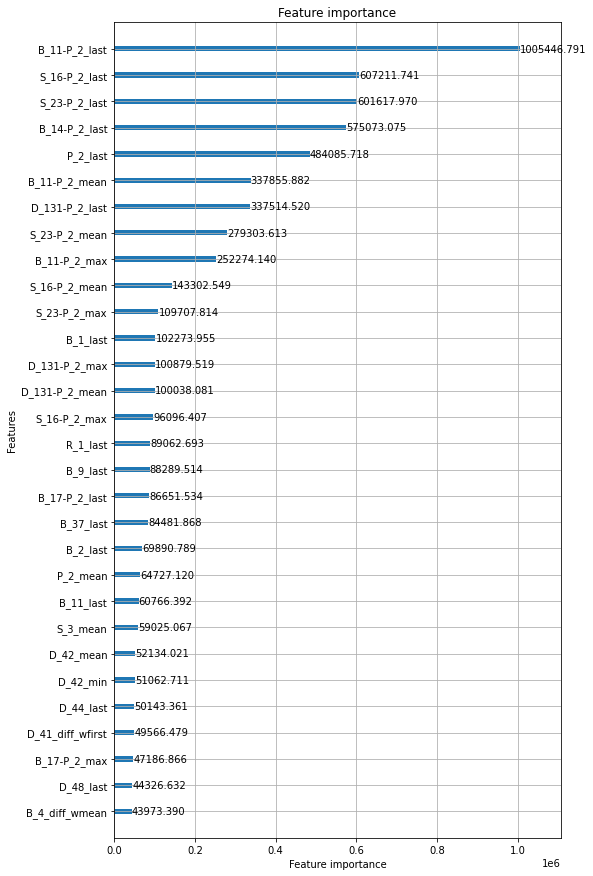

######################################## training model 5/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.759474	valid_0's recall_at4: 0.614096	valid_0's norm_gini: 0.904851
[100]	valid_0's amex_metric: 0.766525	valid_0's recall_at4: 0.623774	valid_0's norm_gini: 0.909276
[150]	valid_0's amex_metric: 0.770497	valid_0's recall_at4: 0.629665	valid_0's norm_gini: 0.911328
[200]	valid_0's amex_metric: 0.773322	valid_0's recall_at4: 0.634126	valid_0's norm_gini: 0.912519
[250]	valid_0's amex_metric: 0.775879	valid_0's recall_at4: 0.637534	valid_0's norm_gini: 0.914223
[300]	valid_0's amex_metric: 0.77844	valid_0's recall_at4: 0.641279	valid_0's norm_gini: 0.915601
[350]	valid_0's amex_metric: 0.779569	valid_0's recall_at4: 0.642584	valid_0's norm_gini: 0.916553
[400]	valid_0's amex_metric: 0.780869	valid_0's recall_at4: 0.644561	valid_0's norm_gini: 0.917177
[450]	valid_0's amex_metric: 0.782457	valid_0's recall_at4: 0.646792	valid_0's norm_gini: 0.918123
[500]	valid_0's amex_metric: 0.784526	valid_0's recall_at4: 0.649821	valid_0's norm_gini: 0.919231
[550]	valid_

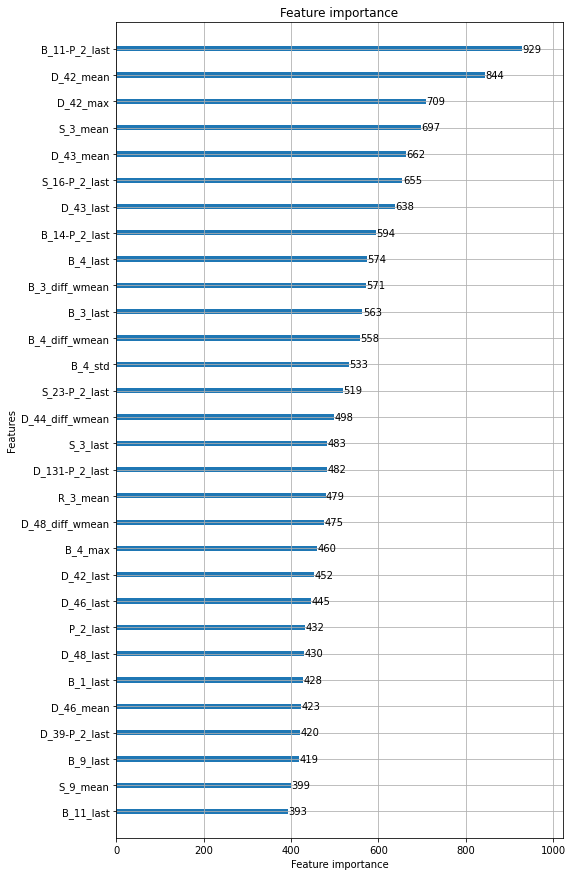

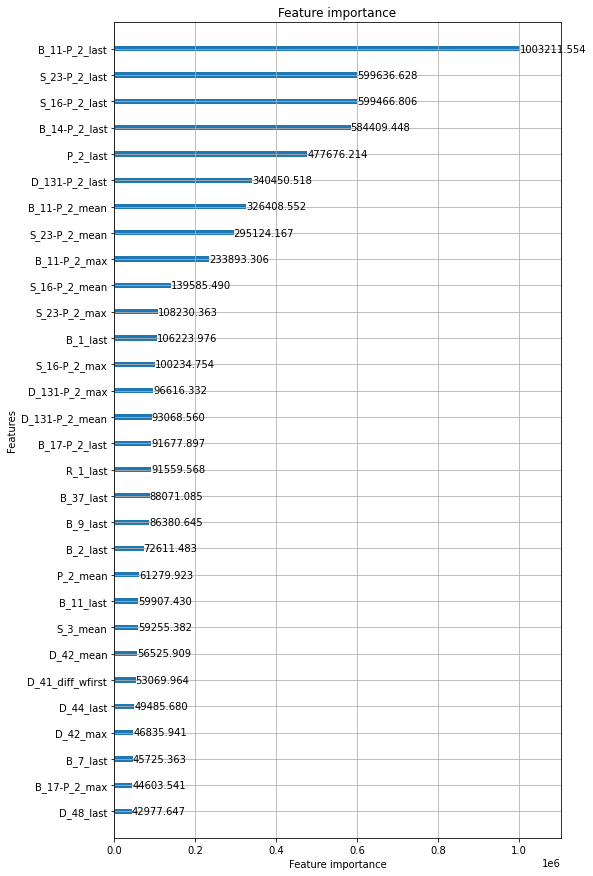

Training time: 118.38210043907165 min.
OOF recall_at4: 0.6679907092604437
OOF normalized_gini: 0.9253806869804797
OOF competition metric: 0.7966856981204617
############################### repeated cross-validation step: 3/3 ################################
######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.754645	valid_0's recall_at4: 0.606917	valid_0's norm_gini: 0.902372
[100]	valid_0's amex_metric: 0.76193	valid_0's recall_at4: 0.616469	valid_0's norm_gini: 0.907391
[150]	valid_0's amex_metric: 0.764709	valid_0's recall_at4: 0.62013	valid_0's norm_gini: 0.909288
[200]	valid_0's amex_metric: 0.766429	valid_0's recall_at4: 0.622276	valid_0's norm_gini: 0.910583
[250]	valid_0's amex_metric: 0.770089	valid_0's recall_at4: 0.627956	valid_0's norm_gini: 0.912221
[300]	valid_0's amex_metric: 0.772372	valid_0's recall_at4: 0.63107	valid_0's norm_gini: 0.913674
[350]	valid_0's amex_metric: 0.774695	valid_0's recall_at4: 0.634688	valid_0's norm_gini: 0.914702
[400]	valid_0's amex_metric: 0.776483	valid_0's recall_at4: 0.637592	valid_0's norm_gini: 0.915374
[450]	valid_0's amex_metric: 0.777615	valid_0's recall_at4: 0.638896	valid_0's norm_gini: 0.916333
[500]	valid_0's amex_metric: 0.780496	valid_0's recall_at4: 0.643566	valid_0's norm_gini: 0.917425
[550]	valid_0'

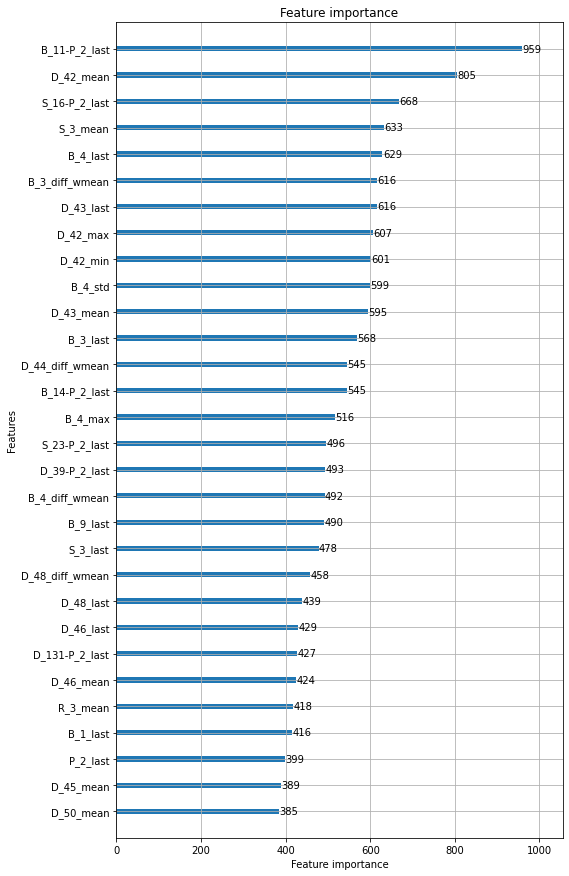

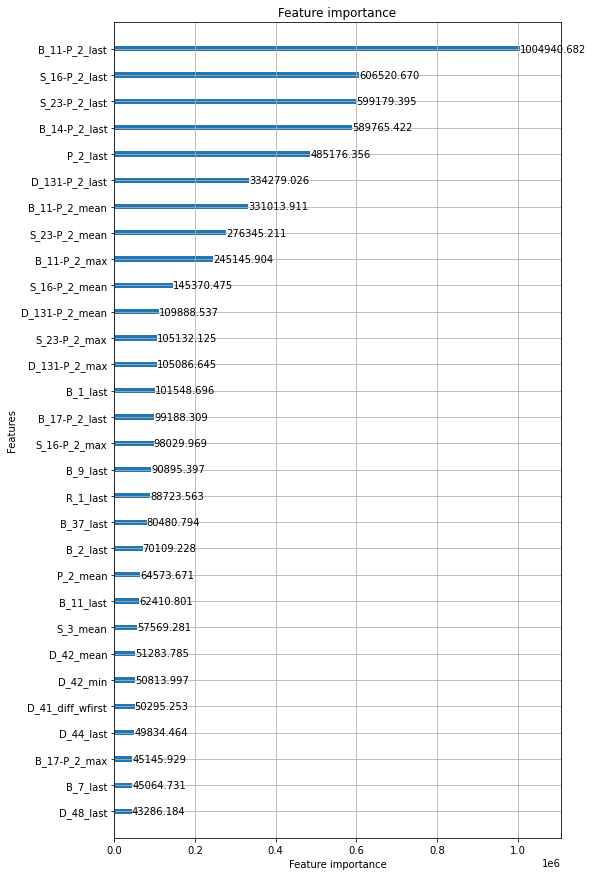

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.754218	valid_0's recall_at4: 0.604519	valid_0's norm_gini: 0.903917
[100]	valid_0's amex_metric: 0.762776	valid_0's recall_at4: 0.617184	valid_0's norm_gini: 0.908367
[150]	valid_0's amex_metric: 0.766322	valid_0's recall_at4: 0.622191	valid_0's norm_gini: 0.910452
[200]	valid_0's amex_metric: 0.768022	valid_0's recall_at4: 0.624379	valid_0's norm_gini: 0.911666
[250]	valid_0's amex_metric: 0.77158	valid_0's recall_at4: 0.629807	valid_0's norm_gini: 0.913352
[300]	valid_0's amex_metric: 0.773876	valid_0's recall_at4: 0.633005	valid_0's norm_gini: 0.914746
[350]	valid_0's amex_metric: 0.775108	valid_0's recall_at4: 0.634604	valid_0's norm_gini: 0.915612
[400]	valid_0's amex_metric: 0.776265	valid_0's recall_at4: 0.636413	valid_0's norm_gini: 0.916117
[450]	valid_0's amex_metric: 0.778302	valid_0's recall_at4: 0.639359	valid_0's norm_gini: 0.917246
[500]	valid_0's amex_metric: 0.780594	valid_0's recall_at4: 0.642809	valid_0's norm_gini: 0.918379
[550]	valid_

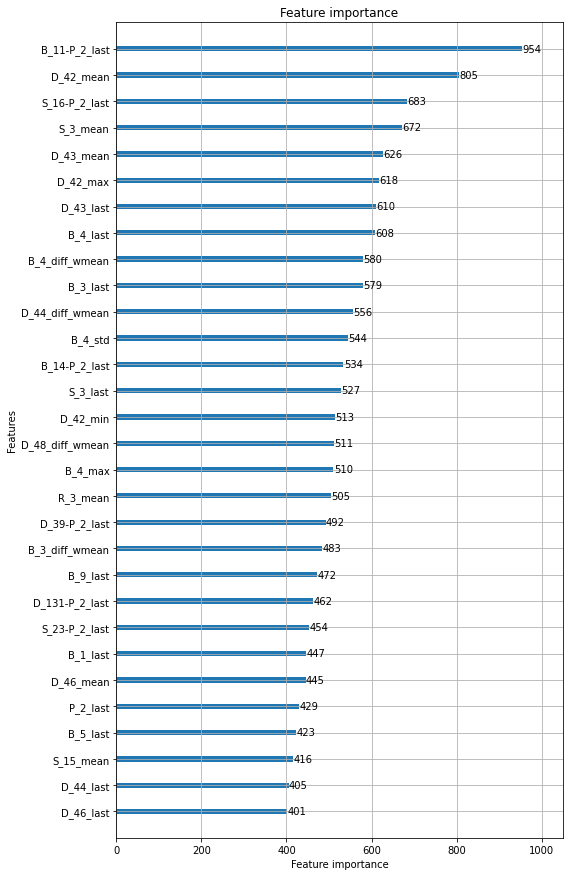

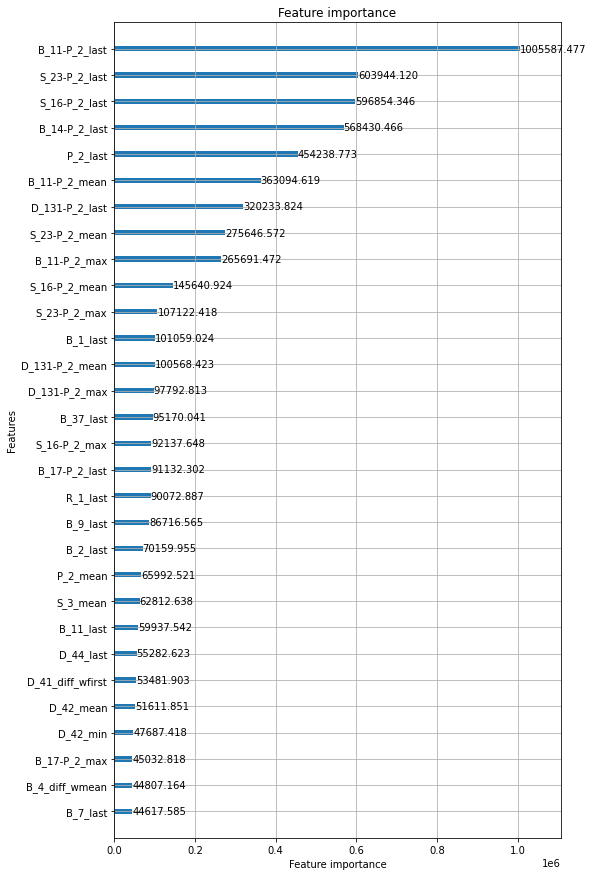

######################################## training model 3/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.758081	valid_0's recall_at4: 0.61365	valid_0's norm_gini: 0.902511
[100]	valid_0's amex_metric: 0.76573	valid_0's recall_at4: 0.623874	valid_0's norm_gini: 0.907585
[150]	valid_0's amex_metric: 0.769716	valid_0's recall_at4: 0.629555	valid_0's norm_gini: 0.909878
[200]	valid_0's amex_metric: 0.771241	valid_0's recall_at4: 0.631322	valid_0's norm_gini: 0.911159
[250]	valid_0's amex_metric: 0.775252	valid_0's recall_at4: 0.637634	valid_0's norm_gini: 0.912871
[300]	valid_0's amex_metric: 0.777137	valid_0's recall_at4: 0.63999	valid_0's norm_gini: 0.914284
[350]	valid_0's amex_metric: 0.778653	valid_0's recall_at4: 0.64201	valid_0's norm_gini: 0.915296
[400]	valid_0's amex_metric: 0.77998	valid_0's recall_at4: 0.643945	valid_0's norm_gini: 0.916014
[450]	valid_0's amex_metric: 0.781322	valid_0's recall_at4: 0.645502	valid_0's norm_gini: 0.917143
[500]	valid_0's amex_metric: 0.783221	valid_0's recall_at4: 0.648111	valid_0's norm_gini: 0.918332
[550]	valid_0's 

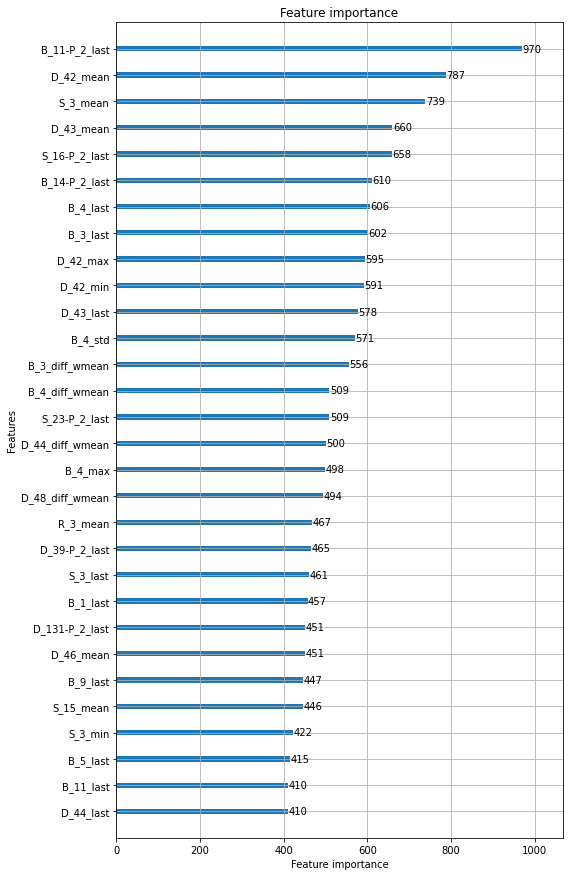

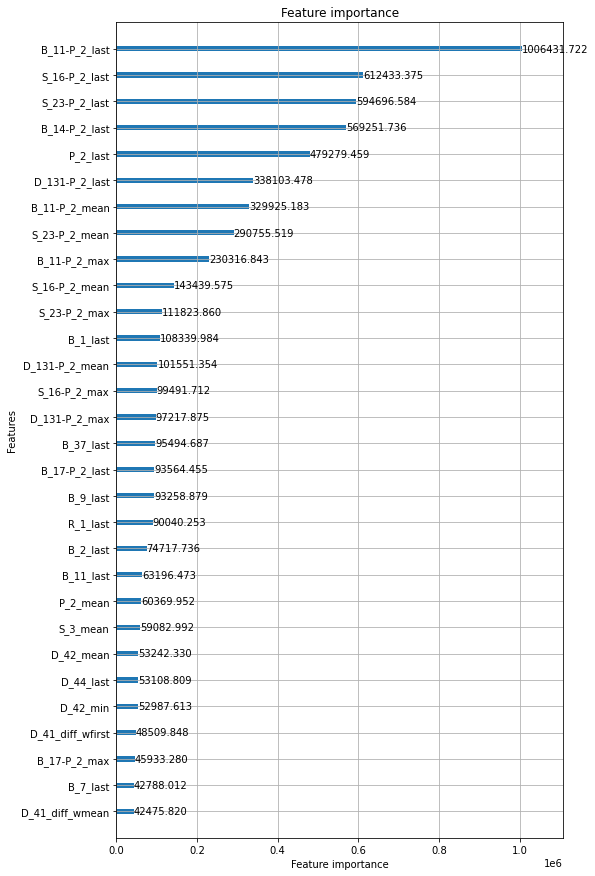

######################################## training model 4/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.762585	valid_0's recall_at4: 0.618388	valid_0's norm_gini: 0.906781
[100]	valid_0's amex_metric: 0.769528	valid_0's recall_at4: 0.627562	valid_0's norm_gini: 0.911495
[150]	valid_0's amex_metric: 0.774506	valid_0's recall_at4: 0.63543	valid_0's norm_gini: 0.913582
[200]	valid_0's amex_metric: 0.777641	valid_0's recall_at4: 0.640438	valid_0's norm_gini: 0.914845
[250]	valid_0's amex_metric: 0.780089	valid_0's recall_at4: 0.643678	valid_0's norm_gini: 0.9165
[300]	valid_0's amex_metric: 0.782158	valid_0's recall_at4: 0.646497	valid_0's norm_gini: 0.91782
[350]	valid_0's amex_metric: 0.784366	valid_0's recall_at4: 0.649905	valid_0's norm_gini: 0.918827
[400]	valid_0's amex_metric: 0.784703	valid_0's recall_at4: 0.649947	valid_0's norm_gini: 0.919459
[450]	valid_0's amex_metric: 0.786631	valid_0's recall_at4: 0.652725	valid_0's norm_gini: 0.920537
[500]	valid_0's amex_metric: 0.7895	valid_0's recall_at4: 0.657269	valid_0's norm_gini: 0.921732
[550]	valid_0's a

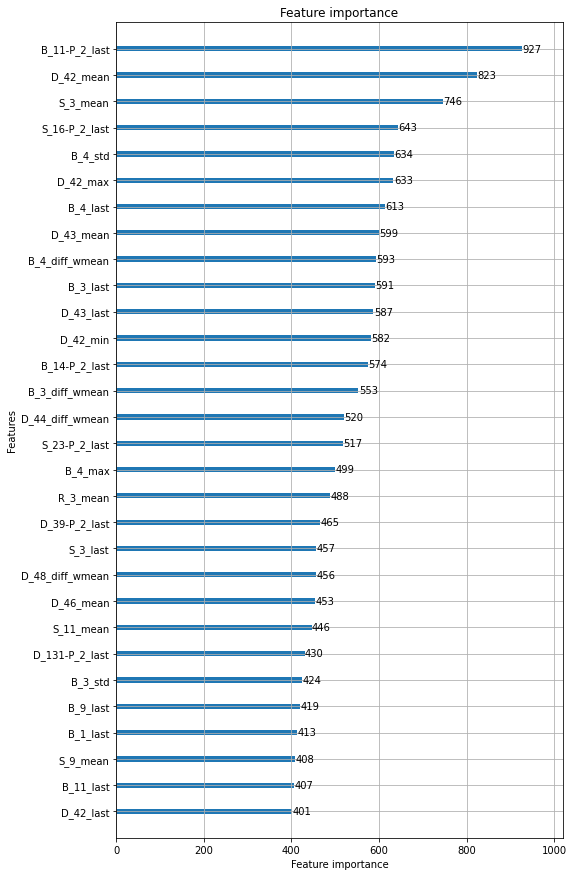

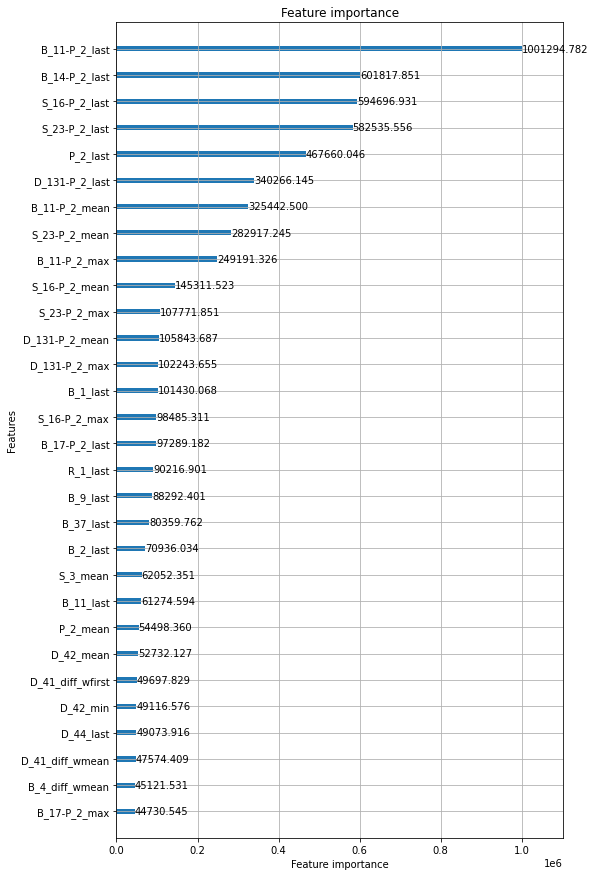

######################################## training model 5/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.757528	valid_0's recall_at4: 0.611992	valid_0's norm_gini: 0.903064
[100]	valid_0's amex_metric: 0.766539	valid_0's recall_at4: 0.625037	valid_0's norm_gini: 0.908041
[150]	valid_0's amex_metric: 0.770388	valid_0's recall_at4: 0.63076	valid_0's norm_gini: 0.910016
[200]	valid_0's amex_metric: 0.772111	valid_0's recall_at4: 0.632906	valid_0's norm_gini: 0.911316
[250]	valid_0's amex_metric: 0.775405	valid_0's recall_at4: 0.637871	valid_0's norm_gini: 0.91294
[300]	valid_0's amex_metric: 0.778051	valid_0's recall_at4: 0.6417	valid_0's norm_gini: 0.914403
[350]	valid_0's amex_metric: 0.77955	valid_0's recall_at4: 0.64372	valid_0's norm_gini: 0.91538
[400]	valid_0's amex_metric: 0.779956	valid_0's recall_at4: 0.643972	valid_0's norm_gini: 0.915939
[450]	valid_0's amex_metric: 0.782055	valid_0's recall_at4: 0.647086	valid_0's norm_gini: 0.917024
[500]	valid_0's amex_metric: 0.783768	valid_0's recall_at4: 0.649527	valid_0's norm_gini: 0.918009
[550]	valid_0's am

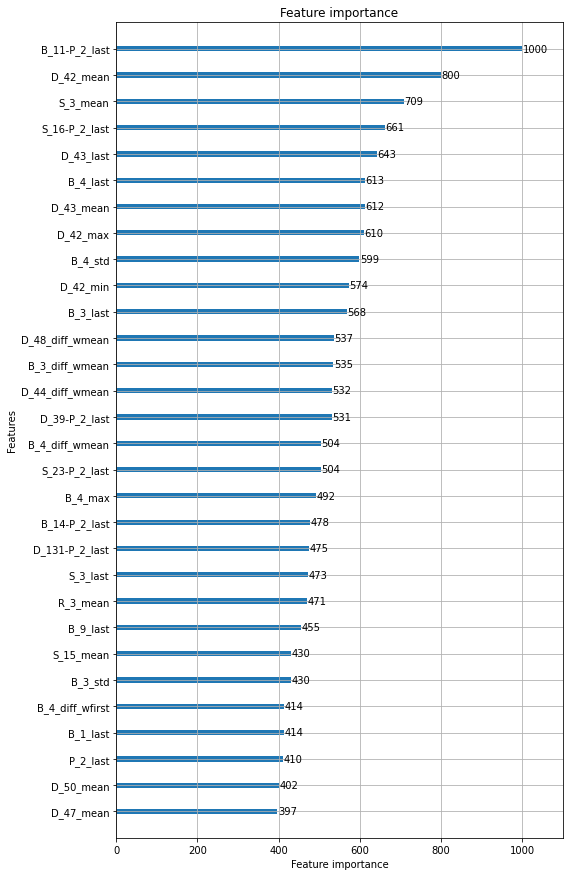

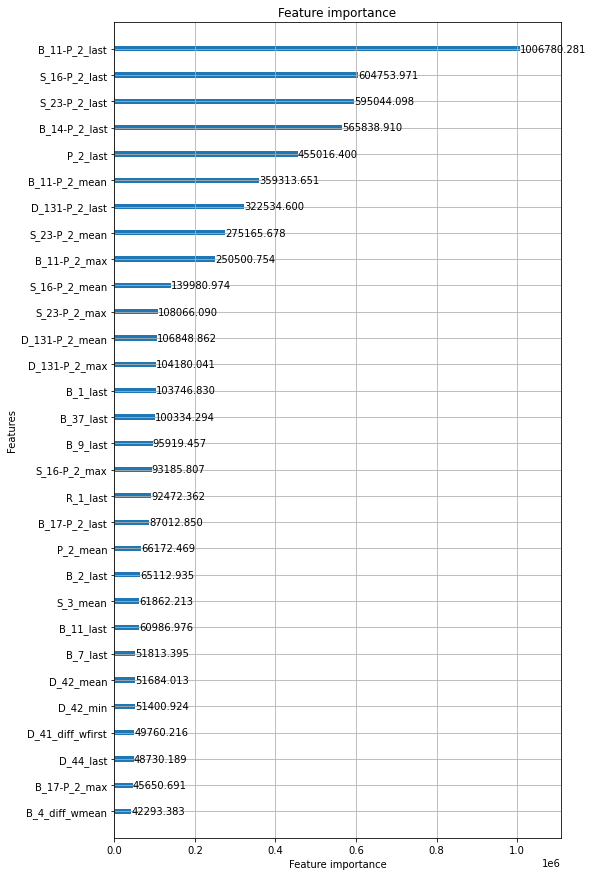

Training time: 119.43954550425211 min.
OOF recall_at4: 0.6687396909819234
OOF normalized_gini: 0.9255443381801818
OOF competition metric: 0.7971420145810526
CPU times: user 3d 12h 51min 25s, sys: 2min, total: 3d 12h 53min 25s
Wall time: 5h 56min 52s


In [12]:
%%time 

all_scalers = list()
all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    scalers,models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_scalers.append(scalers)
    all_models.append(models)
    all_oof_dfs.append(oof)
        
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"model-cv{repetition}-fold{fold}.txt")
    for fold,_scaler in enumerate(scalers):
        joblib.dump(_scaler, ART_PATH/f"scaler-cv{repetition}-fold{fold}.pkl")
          
    del _train, folds; gc.collect()

In [13]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.668159,0.925612,0.796885
1,0.667991,0.925381,0.796686
2,0.668740,0.925544,0.797142



mean:


recall_at4    0.668296
gini          0.925512
metric        0.796904
dtype: float64


std:


recall_at4    0.000393
gini          0.000119
metric        0.000229
dtype: float64

In [14]:
del train, all_oof_dfs
gc.collect()

21

***
## make predictions and submit

In [15]:
def make_predictions(
        dataframe:pd.DataFrame, 
        input_feats:list,
        numeric_feats:list,
        scalers:list,
        models:list,
    ) -> np.array:
    preds = list()
    for scaler,model in zip(scalers,models):
        _dataframe = dataframe.copy()
        _dataframe[numeric_feats] = scaler.transform(_dataframe[numeric_feats])
        preds.append( model.predict(_dataframe[input_feats]) )
    return np.mean(preds, axis=0)     

In [16]:
test = pd.read_parquet("../data/processed/dsv02/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [17]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    scalers = all_scalers[repetition]
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, numeric_feats, scalers, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 3h 59min 59s, sys: 2min 12s, total: 4h 2min 12s
Wall time: 24min 21s


In [18]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.88 s, sys: 82 ms, total: 3.96 s
Wall time: 3.96 s


***